TASC6/KASC13 Workshop
--

---

# Stellar Models for Asteroseismology


by [Earl Patrick Bellinger](https://earlbellinger.com)$^{1,2}$

$^1$_Max Planck Institute for Astrophysics, Garching, Germany_ \
$^2$_Stellar Astrophysics Centre, Aarhus, Denmark_

## Installation

This tutorial is about [MESA](https://docs.mesastar.org/) and [GYRE](https://gyre.readthedocs.io). Let's install them!

In the `src/` directory you will find `install_mesa.sh`. Run it line-by-line so that you may catch any errors that crop up. You will likely need to install some extra packages along the way, and then start over from the beginning. 


Once the installation script is finished, you should see: 


```
************************************************
************************************************
************************************************

MESA installation was successful

************************************************
************************************************
************************************************
```

Hooray! You are ready to get started. 

## Your first MESA run 

Let's copy a fresh work directory over: 

```language:bash
cp -R $MESA_DIR/star/work .
cd work
./mk
./rn
```

## Import packages

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import integrate
from scipy import interpolate

import matplotlib as mpl
import matplotlib.pyplot as plt

import re
import tomso.gyre as gyre
import tomso.fgong as fgong

from ipywidgets import interact, FloatSlider, IntSlider

import tomso

from tqdm import tqdm_notebook as tqdm

In [2]:
import os
import seaborn as sns
sns.set(style="ticks", palette="muted", rc={"xtick.bottom" : True, "ytick.left" : True})
plt.style.use('src/matplotlibrc')

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'

## Read in MESA data

In [4]:
logs_dir = '/afs/mpa/home/earl/temp/binary/M05/LOGS_3MS2/'

In [5]:
DF = pd.read_table(logs_dir + 'history.data', skiprows=5, sep='\s+')
DF

,model_number,star_age,star_mass,mass_conv_core,he_core_mass,he_core_radius,conv_mx1_top,conv_mx1_bot,conv_mx2_top,conv_mx2_bot,...,surface_mg22,surface_mg24,nu_max,delta_nu,delta_Pg,acoustic_cutoff,acoustic_radius,d_log_L_dT,h_exh_core_mass,h_exh_core_radius
0,1663,1.112282e+06,5.0,1.209762,0.0,0.0,0.241631,1.954523e-08,1.0,1.0,...,0.0,0.000734,1246.141882,63.033947,0.000000,1112.945378,7932.233661,-2.904395,0.0,0.0
1,1664,2.447020e+06,5.0,1.206213,0.0,0.0,0.241219,1.954523e-08,1.0,1.0,...,0.0,0.000734,1230.032263,62.389653,0.000000,1097.899911,8014.149390,-3.218789,0.0,0.0
2,1665,3.771701e+06,5.0,1.201524,0.0,0.0,0.239983,1.954522e-08,1.0,1.0,...,0.0,0.000734,1214.548391,61.770727,0.000000,1083.477757,8094.449015,-3.517292,0.0,0.0
3,1666,5.113462e+06,5.0,1.196585,0.0,0.0,0.239159,1.954522e-08,1.0,1.0,...,0.0,0.000734,1199.272591,61.160093,0.000000,1069.282003,8175.265527,-3.779628,0.0,0.0
4,1667,6.519129e+06,5.0,1.191343,0.0,0.0,0.237922,1.954522e-08,1.0,1.0,...,0.0,0.000734,1183.658318,60.535769,0.000000,1054.802530,8259.579593,-4.044228,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,1775,8.673124e+07,5.0,0.567630,0.0,0.0,0.113381,1.954519e-08,1.0,1.0,...,0.0,0.000734,320.488016,21.565331,19460.336021,292.985335,23185.362233,-1.333961,0.0,0.0
113,1776,8.696832e+07,5.0,0.563899,0.0,0.0,0.112601,1.954519e-08,1.0,1.0,...,0.0,0.000734,317.600383,21.408439,19180.293461,290.541385,23355.275966,-1.339467,0.0,0.0
114,1777,8.720389e+07,5.0,0.560178,0.0,0.0,0.111822,1.954519e-08,1.0,1.0,...,0.0,0.000734,314.740950,21.252846,18695.529255,288.115594,23526.261305,-1.347229,0.0,0.0
115,1778,8.743819e+07,5.0,0.556457,0.0,0.0,0.111044,1.954519e-08,1.0,1.0,...,0.0,0.000734,311.907623,21.098443,18107.812040,285.706106,23698.431757,-1.355774,0.0,0.0


In [6]:
index = pd.read_table(logs_dir + 'profiles.index', skiprows=1, sep='\s+',
                     names=['model_number', 'priority', 'profile_number'])
index

,model_number,priority,profile_number
0,1663,2,1
1,1664,1,2
2,1665,1,3
3,1666,1,4
4,1667,1,5
...,...,...,...
112,1775,1,113
113,1776,1,114
114,1777,1,115
115,1778,1,116


In [7]:
def get_history(profile_number):
    model_number = index[index.profile_number == profile_number].model_number.values[0]
    return DF[DF.model_number == model_number]

get_history(10)

,model_number,star_age,star_mass,mass_conv_core,he_core_mass,he_core_radius,conv_mx1_top,conv_mx1_bot,conv_mx2_top,conv_mx2_bot,...,surface_mg22,surface_mg24,nu_max,delta_nu,delta_Pg,acoustic_cutoff,acoustic_radius,d_log_L_dT,h_exh_core_mass,h_exh_core_radius
9,1672,1.411200e+07,5.0,1.159233,0.0,0.0,0.231736,1.954522e-08,1.0,1.0,...,0.0,0.000734,1103.550393,57.320907,0.0,980.901985,8722.820814,-5.027891,0.0,0.0


In [8]:
list(DF.columns)

['model_number',
 'star_age',
 'star_mass',
 'mass_conv_core',
 'he_core_mass',
 'he_core_radius',
 'conv_mx1_top',
 'conv_mx1_bot',
 'conv_mx2_top',
 'conv_mx2_bot',
 'conv_mx1_top_r',
 'conv_mx1_bot_r',
 'conv_mx2_top_r',
 'conv_mx2_bot_r',
 'cz_bot_radius',
 'log_LH',
 'log_LHe',
 'log_Teff',
 'luminosity',
 'log_L',
 'log_R',
 'log_g',
 'log_surf_cell_z',
 'log_center_T',
 'log_center_Rho',
 'log_center_P',
 'center_mu',
 'center_degeneracy',
 'center_h1',
 'center_h2',
 'center_he3',
 'center_he4',
 'center_li7',
 'center_be7',
 'center_b8',
 'center_c12',
 'center_c13',
 'center_n13',
 'center_n14',
 'center_n15',
 'center_o14',
 'center_o15',
 'center_o16',
 'center_o17',
 'center_o18',
 'center_f17',
 'center_f18',
 'center_f19',
 'center_ne18',
 'center_ne19',
 'center_ne20',
 'center_ne22',
 'center_mg22',
 'center_mg24',
 'surface_h1',
 'surface_h2',
 'surface_he3',
 'surface_he4',
 'surface_li7',
 'surface_be7',
 'surface_b8',
 'surface_c12',
 'surface_c13',
 'surface_n13',

In [9]:
DF.delta_Pg

0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.000000
           ...     
112    19460.336021
113    19180.293461
114    18695.529255
115    18107.812040
116    17808.429730
Name: delta_Pg, Length: 117, dtype: float64

### Hertzsprung-Russell Diagram

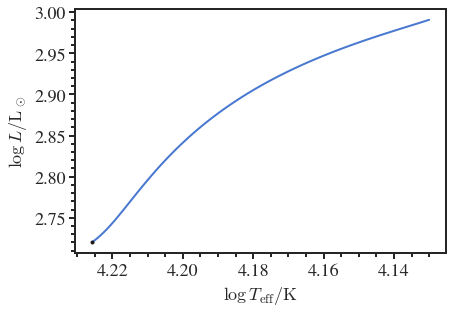

In [10]:
plt.plot(DF['log_Teff'], DF['log_L'])
plt.plot(DF['log_Teff'].values[0], DF['log_L'].values[0], 'k.')
plt.gca().invert_xaxis()
plt.xlabel(r'$\log\,T_{\rm{eff}}/\rm{K}$')
plt.ylabel(r'$\log\,L/\rm{L}_\odot$')
#plt.suptitle('HRD')
plt.show()

## Plot stellar structure 

In [11]:
profnum = '5'

In [12]:
prof = gyre.load_gyre(logs_dir + 'profile' + profnum + '.data.GYRE')

In [13]:
dir(prof)

['AA',
 'Dnu',
 'Dnu_factor',
 'G',
 'Gamma_1',
 'Hp',
 'Hrho',
 'L',
 'L_r',
 'M',
 'N',
 'N2',
 'Omega',
 'P',
 'R',
 'S2_1',
 'S_1',
 'T',
 'Teff',
 'U',
 'V',
 'Vg',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'cs',
 'cs2',
 'dP_dr',
 'data',
 'drho_dr',
 'eps',
 'g',
 'header',
 'k',
 'kappa',
 'lnq',
 'm',
 'n',
 'n_eff',
 'nabla',
 'nu_max',
 'nu_max_factor',
 'q',
 'r',
 'rho',
 'tau',
 'to_amdl',
 'to_fgong',
 'to_file',
 'version',
 'w',
 'x']

In [14]:
model = pd.read_table(logs_dir + 'profile' + profnum + '.data', skiprows=5, sep='\s+')
model.columns

Index(['zone', 'mass', 'logR', 'logT', 'logRho', 'logP', 'x_mass_fraction_H',
       'y_mass_fraction_He', 'z_mass_fraction_metals', 'mu', 'eps_nuc',
       'brunt_N2', 'brunt_N', 'lamb_S'],
      dtype='object')

### Composition profile

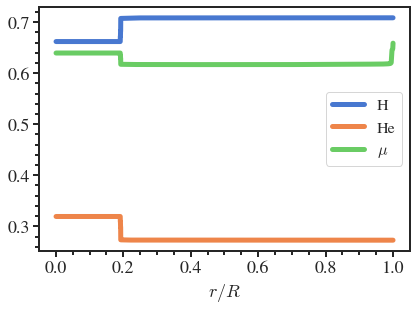

In [15]:
x = 10**model.logR / np.max(10**model.logR)
plt.plot(x, model.x_mass_fraction_H, lw=5, label='H')
plt.plot(x, model.y_mass_fraction_He, lw=5, label='He')
plt.plot(x, model.mu, lw=5, label='$\mu$')
#plt.ylim([0,1])
plt.xlabel(r'$r/R$')
plt.legend()
#plt.ylabel(r'$X$')
plt.show()

### Propagation diagram

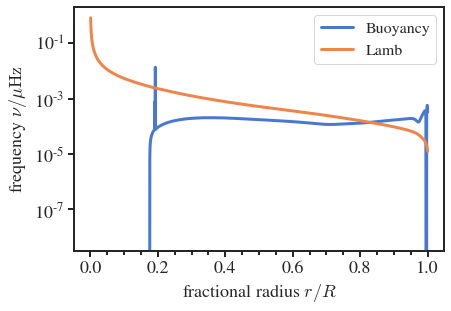

In [16]:
x = 10**model.logR / np.max(10**model.logR)
plt.plot(x, model.brunt_N/(2*np.pi), lw=3, label='Buoyancy')
plt.plot(x, model.lamb_S, lw=3, label='Lamb')
#plt.axhline(get_history(int(profnum)).nu_max.values[0], ls='--', c='k')
plt.ylabel(r'frequency $\nu/\mu\rm{Hz}$')
plt.xlabel(r'fractional radius $r/R$')
plt.legend()
plt.semilogy()
plt.show()

In [17]:
N2 = prof.N2
N = np.sqrt([x if x>=0 else 0 for x in N2])
N

array([0.        , 0.        , 0.        , ..., 0.00970575, 0.00971034,
       0.00971437])

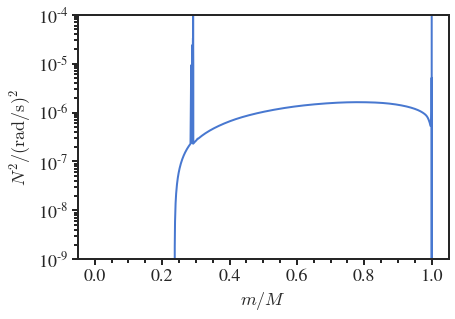

In [18]:
plt.plot(prof.m/prof.M, N2)
plt.xlabel(r'$m/M$')
plt.ylabel(r'$N^2/\left(\rm{rad}/s\right)^2$')
plt.axhline(0, ls='--', c='k', zorder=-1)
plt.ylim([10**-9, 10**-4])
plt.semilogy()
plt.show()

In [19]:
# mu = 4 / (6*prof.X + prof.Y + 2)
mu = interpolate.InterpolatedUnivariateSpline(model[::-1].mass/np.max(model.mass), model[::-1].mu)(prof.m/prof.M)
mu

array([0.63959664, 0.63959664, 0.63959664, ..., 0.65889146, 0.65889146,
       0.65889146])

<ipython-input-20-6fc5d069db26>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(prof.m[1:]/prof.M, np.diff(np.log(mu)) / np.diff(np.log(prof.P)))


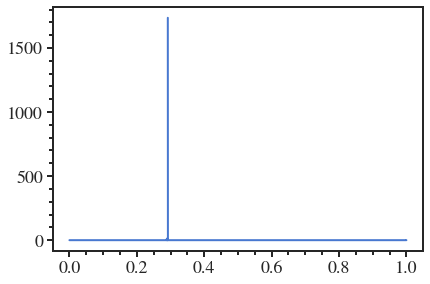

In [20]:
#plt.plot(prof.m/prof.M, np.gradient(np.log(mu), np.log(prof.P)))
plt.plot(prof.m[1:]/prof.M, np.diff(np.log(mu)) / np.diff(np.log(prof.P)))
#plt.plot(prof.m/prof.M, np.log(mu))
#plt.plot(prof.m/prof.M, np.log(prof.P))

<ipython-input-21-7089c5688e87>:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(prof.m[1:]/prof.M, np.diff(np.log(prof.T)) / np.diff(np.log(prof.P)), label=r'$\nabla$')


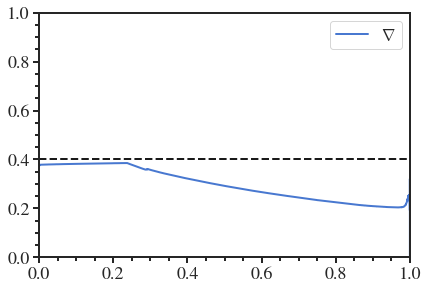

In [21]:
plt.plot(prof.m[1:]/prof.M, np.diff(np.log(prof.T)) / np.diff(np.log(prof.P)), label=r'$\nabla$')
plt.axhline(0.4, c='k', ls='--')
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [22]:
nabla_mu = np.diff(np.log(mu)) / np.diff(np.log(prof.P))
nabla = np.diff(np.log(prof.T)) / np.diff(np.log(prof.P))

<ipython-input-22-e0b7d77965aa>:1: RuntimeWarning: invalid value encountered in true_divide
  nabla_mu = np.diff(np.log(mu)) / np.diff(np.log(prof.P))
<ipython-input-22-e0b7d77965aa>:2: RuntimeWarning: invalid value encountered in true_divide
  nabla = np.diff(np.log(prof.T)) / np.diff(np.log(prof.P))


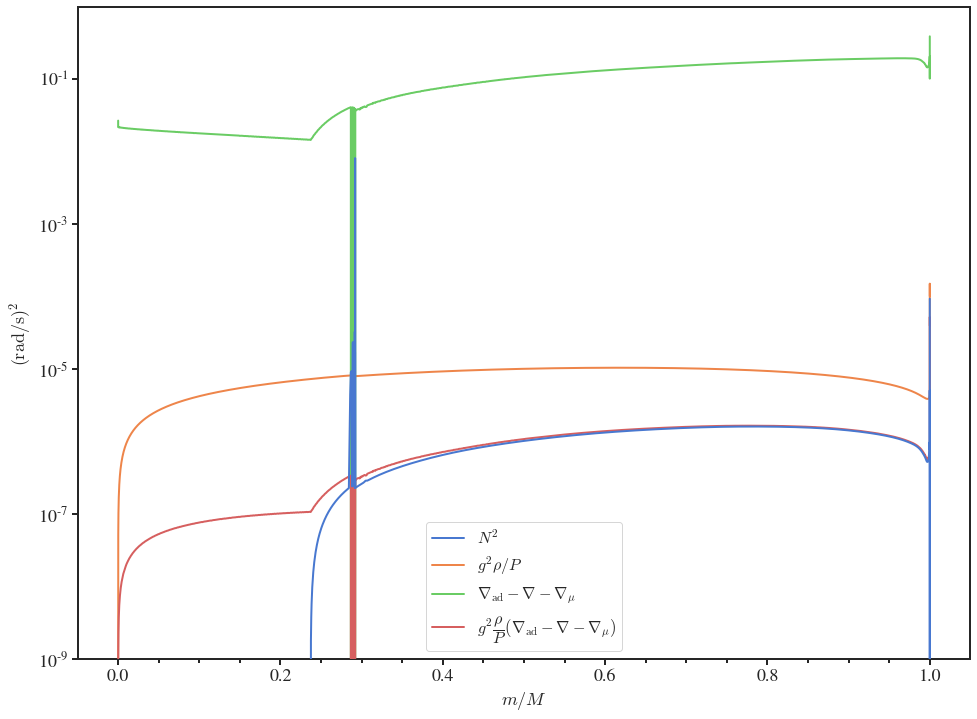

In [23]:
plt.figure(figsize=(16,12))
plt.plot(prof.m/prof.M, N2, label=r'$N^2$', zorder=10, lw=2)
plt.plot(prof.m/prof.M, prof.g**2 * prof.rho / prof.P, label=r'$g^2\rho/P$', lw=2)
#plt.plot(prof.m[1:]/prof.M, nabla_mu, label=r'$\nabla_\mu$')
#plt.plot(prof.m[1:]/prof.M, np.diff(np.log(prof.T)) / np.diff(np.log(prof.P)), label=r'$\nabla$')
plt.plot(prof.m[1:]/prof.M, 0.4 - nabla - nabla_mu, label=r'$\nabla_{\rm{ad}} - \nabla - \nabla_\mu$', lw=2)
plt.plot(prof.m[1:]/prof.M, prof.g[1:]**2 * prof.rho[1:] / prof.P[1:] * (0.4 - nabla - nabla_mu), 
         label=r'$g^2\dfrac{\rho}{P} \left( \nabla_{\rm{ad}} - \nabla - \nabla_\mu \right)$', zorder=5, lw=2)
plt.xlabel(r'$m/M$')
plt.ylabel(r'$\left(\rm{rad}/s\right)^2$')
plt.axhline(0, ls='--', c='k', zorder=-1)
plt.ylim([10**-9, 10**0])
plt.semilogy()
plt.legend()
plt.show()

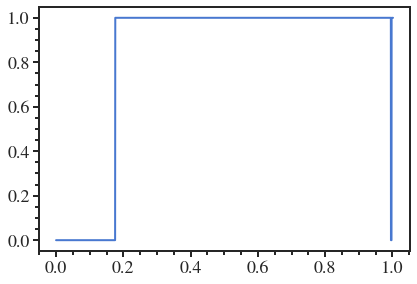

In [24]:
plt.plot(prof.x, prof.N2 > 0)

In [25]:
Pi_0 = 2*np.pi**2/integrate.trapezoid(prof.N[prof.N2>0]/prof.x[prof.N2>0], prof.x[prof.N2>0])
Pi_0

11330.26064612108

In [26]:
Pi_r = 2*np.pi**2/integrate.cumulative_trapezoid(N[prof.N2>0]/prof.x[prof.N2>0], prof.x[prof.N2>0])
Pi_r = np.concatenate(([Pi_r[0]], + Pi_r))
Pi_r

array([1.57203485e+11, 1.57203485e+11, 1.25427854e+09, ...,
       1.13304046e+04, 1.13303279e+04, 1.13302606e+04])

In [27]:
Pi_0 / Pi_r

array([7.20738517e-08, 7.20738517e-08, 9.03328911e-06, ...,
       9.99987291e-01, 9.99994068e-01, 1.00000000e+00])

In [28]:
prof.x[N2>0][np.where(Pi_0/Pi_r >= 0.99999)[0][0]]

1.0015998899370215

### Relative buoyancy radius

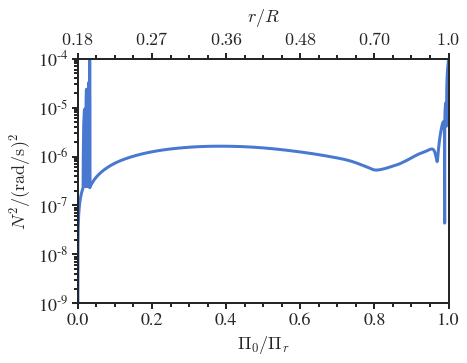

In [29]:
plt.plot(Pi_0 / Pi_r, N2[N2>0], zorder=10, lw=3)
plt.xlabel(r'$\Pi_0/\Pi_r$')
plt.ylabel(r'$N^2/\left(\rm{rad}/s\right)^2$')
plt.xlim([0, 1])
plt.ylim([10**-9, 10**-4])
plt.semilogy()

ax = plt.gca()
top = ax.twiny()
top.set_xlim(ax.get_xlim())
top.set_xlabel(r'$r/R$', labelpad=10)

find_pi = lambda x: prof.x[N2>0][np.where(Pi_0/Pi_r > x)[0][0]]
xs = [0, 0.2, 0.4, 0.6, 0.8, 1]
top.set_xticks(xs)
top.set_xticklabels([r'$%0.2f$' % find_pi(x) if x<0.999 else r'$1.0$' for x in xs])

#plt.grid(zorder=-10)

plt.show()

In [30]:
idx = np.unique(prof.x[prof.N2>0], return_index=True)[1]
x_g = prof.x[prof.N2>0][idx]
N_x = prof.N[prof.N2>0][idx]/x_g
#N_x = interpolate.UnivariateSpline(x_g, prof.N[prof.N2>0][idx]/x_g, s=0)
N_x = sp.ndimage.uniform_filter1d(input=N_x, size=10)
#Pi_0_ = 2*np.pi**2/integrate.trapezoid(N_x(x_g), x_g)
Pi_0_ = 2*np.pi**2/integrate.trapezoid(N_x, x_g)
#Pi_r_ = 2*np.pi**2/integrate.cumulative_trapezoid(N_x(x_g), x_g)
Pi_r_ = 2*np.pi**2/integrate.cumulative_trapezoid(N_x, x_g)
Pi_r_ = np.concatenate(([Pi_r_[0]], + Pi_r_))

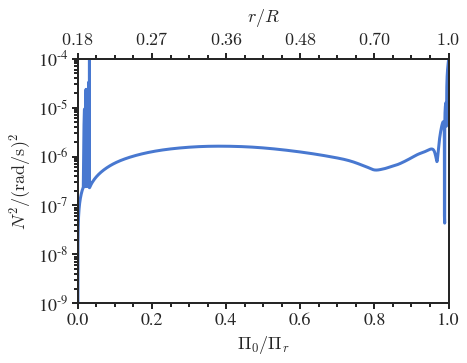

In [31]:
plt.plot(Pi_0_ / Pi_r_, N2[N2>0][idx], zorder=10, lw=3)
plt.xlabel(r'$\Pi_0/\Pi_r$')
plt.ylabel(r'$N^2/\left(\rm{rad}/s\right)^2$')
plt.xlim([0, 1])
plt.ylim([10**-9, 10**-4])
plt.semilogy()

ax = plt.gca()
top = ax.twiny()
top.set_xlim(ax.get_xlim())
top.set_xlabel(r'$r/R$', labelpad=10)

find_pi = lambda x: prof.x[N2>0][idx][np.where(Pi_0_/Pi_r_ > x)[0][0]]
xs = [0, 0.2, 0.4, 0.6, 0.8, 1]
top.set_xticks(xs)
top.set_xticklabels([r'$%0.2f$' % find_pi(x) if x<0.999 else r'$1.0$' for x in xs])

plt.show()

## Periods from GYRE

In [32]:
freqs = pd.read_table(logs_dir + 'profile' + profnum + '-freqs.dat', skiprows=5, sep='\s+')
freqs

,l,n_pg,n_p,n_g,Re(freq),Im(freq),E_norm
0,1,-124,0,124,1.003681,0.0,2.222921e-08
1,1,-123,0,123,1.012136,0.0,2.435846e-08
2,1,-122,0,122,1.020743,0.0,2.668689e-08
3,1,-121,0,121,1.029505,0.0,2.916467e-08
4,1,-120,0,120,1.038427,0.0,3.173501e-08
...,...,...,...,...,...,...,...
120,1,-5,0,5,22.712616,0.0,1.746851e-02
121,1,-4,0,4,28.088219,0.0,4.015497e-02
122,1,-3,0,3,36.083188,0.0,9.775045e-02
123,1,-2,0,2,48.231993,0.0,2.412947e-01


In [33]:
#dipole_g = freqs[np.logical_and(np.logical_and(freqs.l == 1, freqs.n_g > 0), freqs.n_p == 0)] 
dipole_g = freqs[np.logical_and(freqs.l == 1, freqs.n_g > 0)] 
#dipole_g

In [34]:
s_per_day = 86400

In [35]:
dipole_g['P']  = 1/(dipole_g['Re(freq)'] * 10**-6) / s_per_day
#dipole_g

In [36]:
for mode in dipole_g.iterrows():
    n_g  = mode[1]['n_g']
    n_g2 = dipole_g[dipole_g['n_g'] == n_g+1]
    if not n_g2.empty:
        dP = (n_g2['P'].values[0] - mode[1]['P']) * s_per_day # period spacing in seconds 
        dipole_g.loc[mode[0], 'dP'] = dP

dipole_g

,l,n_pg,n_p,n_g,Re(freq),Im(freq),E_norm,P,dP
0,1,-124,0,124,1.003681,0.0,2.222921e-08,11.531629,NaN
1,1,-123,0,123,1.012136,0.0,2.435846e-08,11.435293,8323.423086
2,1,-122,0,122,1.020743,0.0,2.668689e-08,11.338876,8330.489975
3,1,-121,0,121,1.029505,0.0,2.916467e-08,11.242370,8338.120636
4,1,-120,0,120,1.038427,0.0,3.173501e-08,11.145779,8345.424099
...,...,...,...,...,...,...,...,...,...
120,1,-5,0,5,22.712616,0.0,1.746851e-02,0.509588,8701.441122
121,1,-4,0,4,28.088219,0.0,4.015497e-02,0.412062,8426.278395
122,1,-3,0,3,36.083188,0.0,9.775045e-02,0.320761,7888.377101
123,1,-2,0,2,48.231993,0.0,2.412947e-01,0.239967,6980.611778


### Period spacings

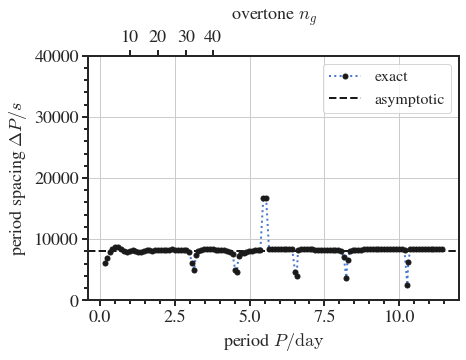

In [37]:
#plt.plot(dipole_g['P'], dipole_g['dP'], 'b.-', ms=10, zorder=10, label='exact')
plt.plot(dipole_g['P'], dipole_g['dP'], 
             'b.--', ms=10, zorder=10, ls=':', mec='k', mfc='k', label='exact')
#plt.xlim([0, 4])
plt.ylim([0, 40000])
plt.axhline(Pi_0 / np.sqrt(2), ls='--', c='k', label=r'asymptotic')
#plt.axhline(0, ls='--', c='k')
plt.xlabel(r'period $P/\rm{day}$')
plt.ylabel(r'period spacing $\Delta P/s$')

plt.legend()

plt.grid()

ax = plt.gca()
top = ax.twiny()
top.set_xlabel(r'overtone $n_g$', labelpad=10)
top.set_xlim(ax.get_xlim())

per_spac = dipole_g[~np.isnan(dipole_g.dP)][::-1]
#per_spac = per_spac[per_spac.P < 4]
#top.set_xticks(per_spac.P, minor=True)
top.set_xticks([], minor=True)

n_g_ = per_spac.iloc[np.unique(per_spac.n_g, return_index=True)[1]]
n_g_ = sp.interpolate.InterpolatedUnivariateSpline(n_g_.n_g, n_g_.P)
top.set_xticks([n_g_(x) for x in [10, 20, 30, 40]])
top.set_xticklabels([10, 20, 30, 40])

#top.set_xticks(per_spac.P.values[[9,19,29,39]])
#top.set_xticklabels([r'$%s$' % x for x in per_spac.n_g.values[[9,19,29,39]]])

plt.show()

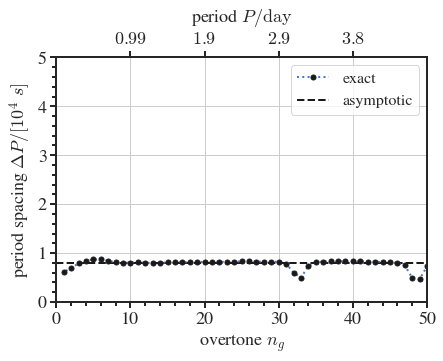

In [38]:
#plt.plot(dipole_g['n_g'], dipole_g['dP'] / 10**4, 'b.-', ms=10, zorder=10, label='exact')
plt.plot(dipole_g['n_g'], dipole_g['dP'] / 10**4, 
             'b.--', ms=10, zorder=10, ls=':', mec='k', mfc='k', label='exact')
plt.xlim([0, 50])
plt.ylim([0, 5])
plt.axhline(Pi_0 / np.sqrt(2) / 10**4, ls='--', c='k', label=r'asymptotic')
#plt.axhline(0, ls='--', c='k')
plt.xlabel(r'overtone $n_g$')
plt.ylabel(r'period spacing $\Delta P/[10^4~s]$')

plt.legend()

plt.grid()

ax = plt.gca()
top = ax.twiny()
top.set_xlabel(r'period $P/\rm{day}$', labelpad=10)
top.set_xlim(ax.get_xlim())

per_spac = dipole_g[~np.isnan(dipole_g.dP)][::-1]
#top.set_xticks([], minor=True)
#top.set_xticks([10, 20, 30, 40])

top.set_xticks([], minor=True)
top.set_xticks([10, 20, 30, 40])

n_g_ = per_spac.iloc[np.unique(per_spac.n_g, return_index=True)[1]]
n_g_ = sp.interpolate.InterpolatedUnivariateSpline(n_g_.n_g, n_g_.P)
#top.set_xticklabels([r'$%.1g$' % per_spac.P[per_spac.n_g == x] for x in [20, 30, 40]])
top.set_xticklabels([r'$%.2g$' % n_g_(x) for x in [10, 20, 30, 40]])

#top.set_xticklabels([r'$%.1g$' % per_spac.P[per_spac.n_g == x] for x in [10, 20, 30, 40]])

plt.show()

### Propagation diagram with periods

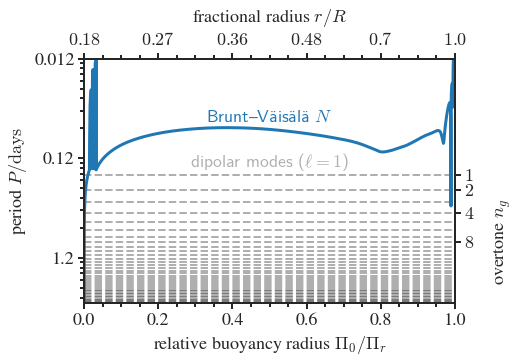

In [39]:
buoy_rad = N[N2>0]/(10**-6 * 2*np.pi)

plt.plot(Pi_0 / Pi_r, buoy_rad, 
         zorder=10, lw=3, label=r'Brunt–Väisälä',
        c='tab:blue')
plt.xlabel(r'relative buoyancy radius $\Pi_0/\Pi_r$')
#plt.ylabel(r'frequency $\nu/\mu\rm{Hz}$')
plt.ylabel(r'period $P/\rm{days}$')
plt.xlim([0,1])
ylim = [3.5, 10**3]
plt.ylim(ylim)
plt.semilogy()

ax = plt.gca()

yticks = [10**1, 10**2, 10**3]
nutoP = lambda x: 1/(x * 10**-6) / s_per_day
ax.set_yticks(yticks)
ax.set_yticklabels(['%2.2g' % nutoP(x) for x in yticks])

plt.text(0.5, buoy_rad[np.where(Pi_0 / Pi_r >= 0.5)[0][0]]*1.2, r'Brunt–Väisälä $N$', ha='center',
        c='tab:blue', family='Latin Modern Sans')
#plt.legend()

for mode in dipole_g.iterrows():
    plt.axhline(mode[1]['Re(freq)'], ls='--', c='k', alpha=0.35)
    if mode[1]['n_g'] == 1:
        plt.text(0.5, mode[1]['Re(freq)']*1.2, r'dipolar modes ($\ell = 1$)', ha='center',
            c='k', alpha=0.35, family='Latin Modern Sans')
    #plt.plot([0,1], [mode[1]['Re(freq)']]*2, ls='--', c='k')

top = ax.twiny()
top.set_xlim(ax.get_xlim())
top.set_xlabel(r'fractional radius $r/R$', labelpad=10)

find_pi = lambda x: prof.x[N2>0][np.where(Pi_0/Pi_r > x)[0][0]]
#xs = [0, 0.25, 0.5, 0.75, 0.99999]
xs = [0, 0.2, 0.4, 0.6, 0.8, 0.99999]
top.set_xticks(xs)
top.set_xticklabels([r'$%0.2g$' % find_pi(x) if x<0.999 else r'$1.0$' for x in xs])

## plot overtones on the right y-axis 
right = ax.twinx()
right.set_ylim(ax.get_ylim())
right.semilogy()
right.set_ylabel(r'overtone $n_g$')
right.yaxis.set_label_coords(1.1,0.25)

per_spac = dipole_g[~np.isnan(dipole_g.dP)]
per_spac = per_spac[per_spac.P < 5]
right.set_yticks(per_spac['Re(freq)'].values[::-1][[0,1,3,7]])
right.set_yticklabels([r'$%s$' % x for x in per_spac.n_g.values[::-1][[0,1,3,7]]])

#right.set_yticks(dipole_g['Re(freq)'], minor=True)
#right.set_yticklabels([], minor=True)
right.set_yticks([], minor=True)
#right.set_yticklabels([], minor=True)

plt.show()

## Eigenfunctions

In [40]:
eig_1 = pd.read_table(logs_dir + 'profile' + profnum + '-freqs/001_-00001', skiprows=5, sep='\s+')
eig_1

,M_r,x,Re(xi_r),Im(xi_r),Re(xi_h),Im(xi_h)
0,0.000000e+00,0.000000,-0.509597,0.0,-0.509597,0.0
1,1.943195e+26,0.000689,-0.509599,0.0,-0.509598,0.0
2,3.886390e+26,0.000868,-0.509600,0.0,-0.509598,0.0
3,7.772778e+26,0.001094,-0.509602,0.0,-0.509599,0.0
4,1.554556e+27,0.001378,-0.509604,0.0,-0.509600,0.0
...,...,...,...,...,...,...
4506,9.942049e+33,1.001596,1.348792,0.0,0.664295,0.0
4507,9.942049e+33,1.001597,1.348797,0.0,0.664292,0.0
4508,9.942049e+33,1.001599,1.348802,0.0,0.664289,0.0
4509,9.942049e+33,1.001600,1.348807,0.0,0.664286,0.0


In [41]:
eigs = {}
for fname in os.listdir(logs_dir + 'profile' + profnum + '-freqs'):
    if fname[:4] != '001_':
        continue
    eig_i = pd.read_table(logs_dir + 'profile' + profnum + '-freqs/' + fname, sep='\s+', skiprows=5)
    eig_i = eig_i.iloc[np.unique(eig_i.x, return_index=True)[1]]
    eigs[int(fname.split('_')[1])] = eig_i

In [42]:
eigs[-1].x

0       0.000000
1       0.000689
2       0.000868
3       0.001094
4       0.001378
          ...   
4506    1.001596
4507    1.001597
4508    1.001599
4509    1.001600
4510    1.001601
Name: x, Length: 4510, dtype: float64

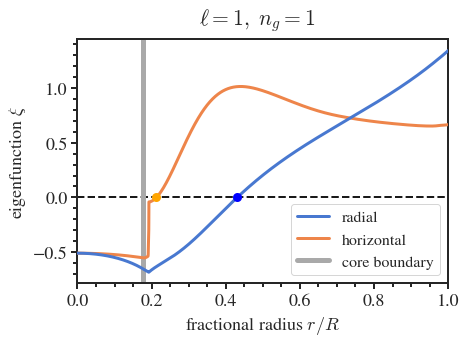

In [43]:
eig = eigs[-1] #eig_1
plt.plot(eig.x, eig['Re(xi_r)'], label='radial', lw=3, zorder=11)
plt.plot(eig.x, eig['Re(xi_h)'], label='horizontal', lw=3, zorder=10)
plt.xlim([0,1])
[plt.plot(r, 0, 'o', mew=3, zorder=100, c='blue') 
 for r in interpolate.InterpolatedUnivariateSpline(eig.x, eig['Re(xi_r)']).roots()]
[plt.plot(r, 0, 'o', mew=3, zorder=100, c='orange') 
 for r in interpolate.InterpolatedUnivariateSpline(eig.x, eig['Re(xi_h)']).roots()]
plt.xlabel(r'fractional radius $r/R$')
plt.ylabel(r'eigenfunction $\xi$')
plt.axhline(0, ls='--', c='k', alpha=1, zorder=-10)
plt.axvline(find_pi(0), ls='-', lw=5, c='darkgray', label='core boundary', zorder=-10)
#plt.grid()
plt.suptitle(r'$\ell = 1,\; n_g = 1$')
plt.legend()
plt.show()

### Eigenfunctions with slider 

In [44]:
def plot_eigs(n_g):
    eig = eigs[-n_g] 
    plt.plot(eig.x, eig['Re(xi_r)'], label='radial', lw=3, zorder=11)
    plt.plot(eig.x, eig['Re(xi_h)'], label='horizontal', lw=3, zorder=10)
    plt.xlim([0,1])
    [plt.plot(r, 0, 'o', mew=3, zorder=100, c='blue') 
     for r in interpolate.InterpolatedUnivariateSpline(eig.x, eig['Re(xi_r)']).roots()]
    [plt.plot(r, 0, 'o', mew=3, zorder=100, c='orange') 
     for r in interpolate.InterpolatedUnivariateSpline(eig.x, eig['Re(xi_h)']).roots()]
    plt.xlabel(r'fractional radius $r/R$')
    plt.ylabel(r'eigenfunction $\xi$')
    plt.axhline(0, ls='--', c='k', alpha=1, zorder=-10)
    plt.axvline(find_pi(0), ls='-', lw=5, c='darkgray', label='core boundary', zorder=-10)
    #plt.grid()
    plt.suptitle(r'$\ell = 1,\; n_g = ' + str(n_g) + r'$')
    plt.legend()
    plt.show()

interact(plot_eigs, n_g=IntSlider(min=1, max=16, step=1, value=2, 
                       continuous_update=True));

interactive(children=(IntSlider(value=2, description='n_g', max=16, min=1), Output()), _dom_classes=('widget-i…

In [111]:
# plot in terms of Pi_0 / Pi_r 

### Phase diagrams

In [49]:
def plot_phase(n_g):
    eig = eigs[-n_g] 
    plt.plot(eig['Re(xi_r)'], eig['Re(xi_h)'], lw=3, zorder=11)
    plt.xlabel(r'radial displacement $\xi_r$')
    plt.ylabel(r'horizontal displacement $\xi_h$')
    plt.axhline(0, ls='--', c='k', alpha=1, zorder=-10)
    plt.axvline(0, ls='--', c='k', alpha=1, zorder=-10)
    plt.xlim([-5, 5])
    plt.ylim([-50, 50])
    plt.suptitle(r'$\ell = 1,\; n_g = ' + str(n_g) + r'$')
    plt.show()

interact(plot_phase, n_g=IntSlider(min=1, max=50, step=1, value=35, 
                       continuous_update=True));

interactive(children=(IntSlider(value=20, description='n_g', max=50, min=1), Output()), _dom_classes=('widget-…

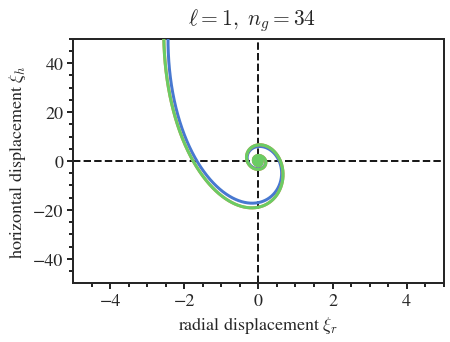

In [50]:
for n_g in [33, 34, 34]:
    eig = eigs[-n_g] 
    plt.plot(eig['Re(xi_r)'], eig['Re(xi_h)'], lw=3, zorder=11)

plt.xlabel(r'radial displacement $\xi_r$')
plt.ylabel(r'horizontal displacement $\xi_h$')
plt.axhline(0, ls='--', c='k', alpha=1, zorder=-10)
plt.axvline(0, ls='--', c='k', alpha=1, zorder=-10)
plt.xlim([-5, 5])
plt.ylim([-50, 50])
plt.show()

### Mode trappings

In [51]:
eig.M_r

0        0.000000e+00
1        9.715994e+25
2        1.943197e+26
3        3.886391e+26
4        7.772780e+26
             ...     
10323    9.942049e+33
10324    9.942049e+33
10325    9.942049e+33
10326    9.942049e+33
10327    9.942049e+33
Name: M_r, Length: 10283, dtype: float64

In [52]:
eig = eigs[-10]
angle_x = integrate.trapezoid(eig['Re(xi_r)']**2 * eig.x, eig.M_r) / \
          integrate.trapezoid(eig['Re(xi_r)']**2,         eig.M_r)
angle_x

0.40670113382827544

In [53]:
n_gs = []
angle_xs = []

for mode in dipole_g.iterrows():
    n_g = mode[1]['n_g']
    eig = eigs[-n_g]
    angle_x = integrate.trapezoid(eig['Re(xi_r)']**2 * eig.x, eig.M_r) / \
              integrate.trapezoid(eig['Re(xi_r)']**2,         eig.M_r)
    dipole_g.loc[mode[0], 'trap'] = angle_x
    #n_gs += [n_g]
    #angle_xs += [angle_x]


#### Trappings and period spacings

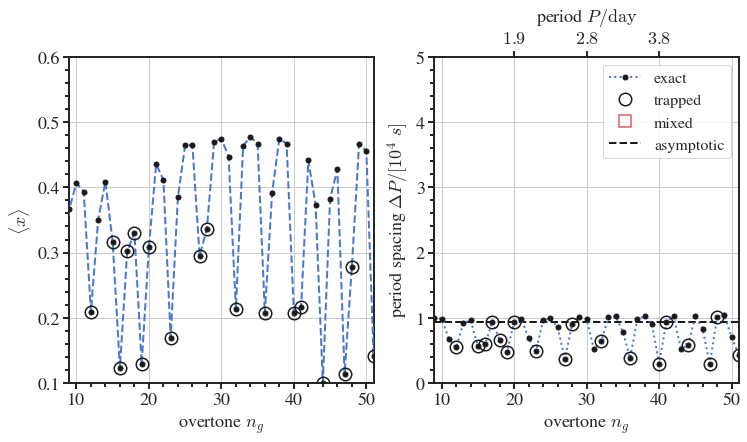

In [54]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)

plt.plot(dipole_g.n_g, dipole_g.trap, 'b.--', ms=10, zorder=10, ls='--', mec='k', mfc='k')
#plt.plot(dipole_g.n_g, dipole_g.trap, 'b.-', ms=10, zorder=10, ls='--', mec='k', mfc='k')
cutoff = 0.825*np.median(dipole_g.trap[10:])
plt.plot(dipole_g[dipole_g.trap<cutoff].n_g, 
         dipole_g[dipole_g.trap<cutoff].trap, 
         'ko', fillstyle='none', mew=1.5, ms=12.5, zorder=15)
#plt.axhline(cutoff, ls='--', c='k')
plt.xlim([9, 51])
plt.ylim([0.1, 0.6])
plt.xlabel(r'overtone $n_g$')
plt.ylabel(r'$\langle x \rangle$')
plt.grid()


plt.subplot(1,2,2)

plt.plot(dipole_g['n_g'], dipole_g['dP'] / 10**4, 'b.--', ms=10, zorder=10, ls=':', mec='k', mfc='k', label='exact')
plt.plot(dipole_g['n_g'][dipole_g.trap<cutoff], 
         dipole_g['dP'][dipole_g.trap<cutoff] / 10**4, 
         'ko', fillstyle='none', mew=1.5, ms=12.5, zorder=15, label='trapped')
plt.plot(dipole_g['n_g'][dipole_g.n_p>0], 
         dipole_g['dP'][dipole_g.n_p>0] / 10**4, 
         'rs', fillstyle='none', mew=1.5, ms=12.5, zorder=15, label='mixed')
plt.plot(dipole_g['n_g'][dipole_g.n_p>0], 
         dipole_g['trap'][dipole_g.n_p>0], 
         'rs', fillstyle='none', mew=1.5, ms=12.5, zorder=15)
plt.xlim([9, 51])
plt.ylim([0, 5])
plt.axhline(Pi_0 / np.sqrt(2) / 10**4, ls='--', c='k', label=r'asymptotic')
#plt.axhline(0, ls='--', c='k')
plt.xlabel(r'overtone $n_g$')
plt.ylabel(r'period spacing $\Delta P/[10^4~s]$')

plt.legend()

plt.grid()

ax = plt.gca()
top = ax.twiny()
top.set_xlabel(r'period $P/\rm{day}$', labelpad=10)
top.set_xlim(ax.get_xlim())

per_spac = dipole_g[~np.isnan(dipole_g.dP)][::-1]
top.set_xticks([], minor=True)
top.set_xticks([20, 30, 40])

n_g_ = per_spac.iloc[np.unique(per_spac.n_g, return_index=True)[1]]
n_g_ = sp.interpolate.InterpolatedUnivariateSpline(n_g_.n_g, n_g_.P)
#top.set_xticklabels([r'$%.1g$' % per_spac.P[per_spac.n_g == x] for x in [20, 30, 40]])
top.set_xticklabels([r'$%.2g$' % n_g_(x) for x in [20, 30, 40]])

plt.show()

### Propagation diagram with eigenfunctions

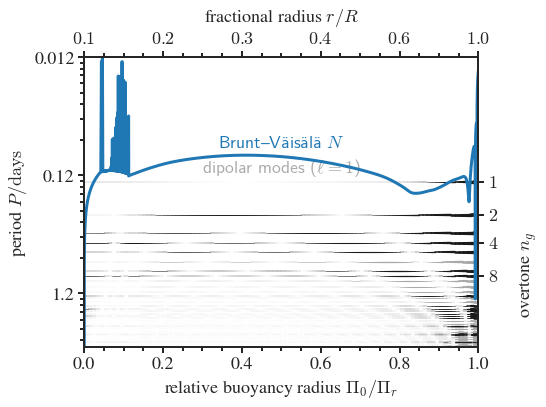

In [55]:
buoy_rad = N[N2>0]/(10**-6 * 2*np.pi)
find_pi = lambda x: prof.x[N2>0][np.where(Pi_0/Pi_r > x)[0][0]]

plt.figure(figsize=(8,6))

plt.plot(Pi_0 / Pi_r, buoy_rad, 
         zorder=10, lw=3, label=r'Brunt–Väisälä',
        c='tab:blue')
plt.xlabel(r'relative buoyancy radius $\Pi_0/\Pi_r$')
#plt.ylabel(r'frequency $\nu/\mu\rm{Hz}$')
plt.ylabel(r'period $P/\rm{days}$')
plt.xlim([0,1])
ylim = [3.5, 10**3]
plt.ylim(ylim)
plt.semilogy()

ax = plt.gca()

yticks = [10**1, 10**2, 10**3]
nutoP = lambda x: 1/(x * 10**-6) / s_per_day
ax.set_yticks(yticks)
ax.set_yticklabels(['%2.2g' % nutoP(x) for x in yticks])

plt.text(0.5, buoy_rad[np.where(Pi_0 / Pi_r >= 0.5)[0][0]]*1.2, r'Brunt–Väisälä $N$', ha='center',
        c='tab:blue', family='Latin Modern Sans')
#plt.legend()

# plot eigenfunctions 
xs = np.linspace(0, 1, 101)
for mode in dipole_g.iterrows():
    #plt.axhline(mode[1]['Re(freq)'], ls='--', c='k', alpha=0.35)
    eig = eigs[-mode[1]['n_g']]
    xir = np.abs(eig['Re(xi_r)']) / np.max(np.abs(eig['Re(xi_r)'])) * 4 / np.log10(10+mode[1]['n_g'])
    for ii in range(len(xs)-1):
        x_i = (xs[ii]+xs[ii+1])/2
        plt.plot([xs[ii], xs[ii+1]], [mode[1]['Re(freq)']]*2, 
                 ls='-', c='darkgray' if mode[1].trap>cutoff else 'k', alpha=1, ms=0,
                 lw=xir[ np.argmin(np.abs(eig.x - find_pi(x_i))) ] )
    #xih = np.abs(eig['Re(xi_h)']) / np.max(np.abs(eig['Re(xi_h)'])) * 5
    #for ii in range(len(xs)-1):
    #    plt.plot([xs[ii], xs[ii+1]], [mode[1]['Re(freq)']]*2, ls='-', c='darkgray', alpha=1, ms=0,
    #             lw=xih[ np.argmin(np.abs(eig.x - find_pi((xs[ii]+xs[ii+1])/2))) ] )
    if mode[1]['n_g'] == 1:
        plt.text(0.5, mode[1]['Re(freq)']*1.2, r'dipolar modes ($\ell = 1$)', ha='center',
            c='darkgray', family='Latin Modern Sans')

top = ax.twiny()
top.set_xlim(ax.get_xlim())
top.set_xlabel(r'fractional radius $r/R$', labelpad=10)

xs = [0, 0.2, 0.4, 0.6, 0.8, 0.99999]
top.set_xticks(xs)
top.set_xticklabels([r'$%0.1f$' % find_pi(x) if x<0.999 else r'$1.0$' for x in xs])

## plot overtones on the right y-axis 
right = ax.twinx()
right.set_ylim(ax.get_ylim())
right.semilogy()
right.set_ylabel(r'overtone $n_g$')
right.yaxis.set_label_coords(1.1,0.25)

per_spac = dipole_g[~np.isnan(dipole_g.dP)]
per_spac = per_spac[per_spac.P < 5]
right.set_yticks(per_spac['Re(freq)'].values[::-1][[0,1,3,7]])
right.set_yticklabels([r'$%s$' % x for x in per_spac.n_g.values[::-1][[0,1,3,7]]])
right.set_yticks([], minor=True)

plt.tight_layout()
#plt.savefig('propagation.pdf')

plt.show()

### Propagation diagram with $\mu$ and $\xi$

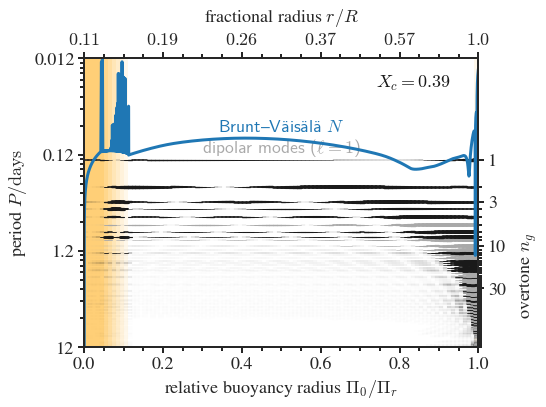

In [56]:
buoy_rad = N[N2>0]/(10**-6 * 2*np.pi)
find_pi = lambda x: prof.x[N2>0][np.where(Pi_0/Pi_r > x)[0][0]]

plt.figure(figsize=(8,6))

plt.plot(Pi_0 / Pi_r, buoy_rad, 
         zorder=10, lw=3, label=r'Brunt–Väisälä',
        c='tab:blue')
plt.xlabel(r'relative buoyancy radius $\Pi_0/\Pi_r$')
#plt.ylabel(r'frequency $\nu/\mu\rm{Hz}$')
plt.ylabel(r'period $P/\rm{days}$')
plt.xlim([0,1])
ylim = [1, 10**3]
plt.ylim(ylim)
plt.semilogy()

ax = plt.gca()

yticks = [10**0, 10**1, 10**2, 10**3]
nutoP = lambda x: 1/(x * 10**-6) / s_per_day
ax.set_yticks(yticks)
ax.set_yticklabels(['%2.2g' % nutoP(x) for x in yticks])

plt.text(0.5, buoy_rad[np.where(Pi_0 / Pi_r >= 0.5)[0][0]]*1.2, r'Brunt–Väisälä $N$', ha='center',
        c='tab:blue', family='Latin Modern Sans')
#plt.legend()

plt.text(0.93, ylim[1]*0.5, r'$X_c = %.2f$' % model.x_mass_fraction_H.values[-1], 
         ha='right', c='k', family='Latin Modern Sans')

# plot mu
# mu ~= 4 / (6*X + Y + 2)
norm = mpl.colors.Normalize(vmin=0.62, vmax=4/3)
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white","orange","red"])
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
x = 10**model.logR / np.max(10**model.logR)
xs = np.linspace(0, 1, 101)
for ii in range(len(xs)-1):
    x_i = (xs[ii]+xs[ii+1])/2
    col = cmap.to_rgba( model.mu[ np.argmin(np.abs(x - find_pi(x_i))) ] )
    plt.axvspan(xs[ii], xs[ii+1], zorder=-100, fc=col, ec=col)

# plot eigenfunctions 
for mode in dipole_g.iterrows():
    #plt.axhline(mode[1]['Re(freq)'], ls='--', c='k', alpha=0.35)
    eig = eigs[-mode[1]['n_g']]
    #xir = np.abs(eig['Re(xi_r)']) / np.max(np.abs(eig['Re(xi_r)'])) * 4 #/ np.log10(10+mode[1]['n_g'])
    #for ii in range(len(xs)-1):
    #    x_i = (xs[ii]+xs[ii+1])/2
    #    plt.plot([xs[ii], xs[ii+1]], [mode[1]['Re(freq)']]*2, 
    #             ls='-', c='darkgray', alpha=1, ms=0,
    #             lw=xir[ np.argmin(np.abs(eig.x - find_pi(x_i))) ] )
    xih = np.abs(eig['Re(xi_h)']) / np.max(np.abs(eig['Re(xi_h)'])) * 4 #/ np.log10(10+mode[1]['n_g'])
    for ii in range(len(xs)-1):
        x_i = (xs[ii]+xs[ii+1])/2
        plt.plot([xs[ii], xs[ii+1]], [mode[1]['Re(freq)']]*2, ls='-', 
                 c='darkgray' if mode[1].trap>cutoff else 'k',
                 alpha=1, ms=0,
                 lw=xih[ np.argmin(np.abs(eig.x - find_pi(x_i))) ] )
    if mode[1]['n_g'] == 1:
        plt.text(0.5, mode[1]['Re(freq)']*1.2, r'dipolar modes ($\ell = 1$)', ha='center',
            c='darkgray', family='Latin Modern Sans')

top = ax.twiny()
top.set_xlim(ax.get_xlim())
top.set_xlabel(r'fractional radius $r/R$', labelpad=10)

xs = [0, 0.2, 0.4, 0.6, 0.8, 0.99999]
top.set_xticks(xs)
top.set_xticklabels([r'$%0.2f$' % find_pi(x) if x<0.999 else r'$1.0$' for x in xs])

## plot overtones on the right y-axis 
right = ax.twinx()
right.set_ylim(ax.get_ylim())
right.semilogy()
right.set_ylabel(r'overtone $n_g$')
right.yaxis.set_label_coords(1.1,0.25)

#per_spac = dipole_g[~np.isnan(dipole_g.dP)]
#per_spac = per_spac[per_spac.P < 5]
#right.set_yticks(per_spac['Re(freq)'].values[::-1][[0,1,3,7,15,31]])
#right.set_yticklabels([r'$%s$' % x for x in per_spac.n_g.values[::-1][[0,1,3,7,15,31]]])
right.set_yticks([dipole_g['Re(freq)'].values[dipole_g.n_g == x][0] for x in [1, 3, 10, 30]])
right.set_yticklabels([1, 3, 10, 30])
right.set_yticks([x for x in dipole_g['Re(freq)'].values if x > ylim[0]], minor=True)
right.set_yticklabels([], minor=True)

plt.tight_layout()
#plt.savefig('propagation.pdf')

plt.show()

## Entire track

In [ ]:
#X_c      = []
delta_Pi = []
periods = {}
delta_P = {}

class track:
    for n_g in range(1, 50):
        delta_P[n_g] = []
        periods[n_g] = []

    for profnum in range(1,1+len(DF)):
        profnum = str(profnum)
        prof = gyre.load_gyre(logs_dir + 'profile' + profnum + '.data.GYRE')
        model = pd.read_table(logs_dir + 'profile' + profnum + '.data', skiprows=5, sep='\s+')
        N2 = prof.N2
        N = np.sqrt([x if x>=0 else 0 for x in N2])

        Pi_0 = 2*np.pi**2/integrate.trapezoid(N[N2>0]/prof.x[N2>0], prof.x[N2>0])
        delta_Pi += [Pi_0 / np.sqrt(2)]

        freqs = pd.read_table(logs_dir + 'profile' + profnum + '-freqs.dat', skiprows=5, sep='\s+')
        #dipole_g = freqs[np.logical_and(freqs.l == 1, freqs.n_g > 0)] 
        dipole_g = freqs[np.logical_and(np.logical_and(freqs.l == 1, freqs.n_g > 0), freqs.n_p <= 0)] 
        dipole_g['P']  = 1/(dipole_g['Re(freq)'] * 10**-6) / s_per_day
        for mode in dipole_g.iterrows():
            n_g  = mode[1]['n_g']
            n_g2 = dipole_g[dipole_g['n_g'] == n_g+1]
            if not n_g2.empty:
                dP = (n_g2['P'].values[0] - mode[1]['P']) * s_per_day # period spacing in seconds 
                dipole_g.loc[mode[0], 'dP'] = dP

        for n_g in range(1, 50):
            #if n_g in dipole_g.n_g:
            n_g_ = dipole_g[dipole_g.n_g == n_g]
            if not n_g_.empty:
                #print(n_g_)
                delta_P[n_g] += [n_g_.dP.values[0]]
                periods[n_g] += [n_g_.P.values[0]]
            else:
                delta_P[n_g] += [np.nan]
                periods[n_g] += [np.nan]
    

### Evolution of asymptotic period spacing 

In [ ]:
plt.plot(DF.center_h1, delta_Pi, lw=3, c='k')
plt.ylabel(r'period spacing $\Delta \Pi_1/s$')
plt.xlabel(r'central hydrogen $X_c$')
plt.xlim([0.68, 0.12])
#plt.ylim([0.4, 3.6])

ax = plt.gca()
top = ax.twiny()
top.set_xlabel(r'age $\tau/\rm{Myr}$', labelpad=10)
top.set_xlim(ax.get_xlim())

top.set_xticks([], minor=True)
top.set_xticks([0.6, 0.5, 0.4, 0.3, 0.2])

plt.show()

In [ ]:
fig = plt.figure(figsize=(6,4))

norm = mpl.colors.Normalize(vmin=1, vmax=49)
#cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white","orange"])
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='tab20c')

periods_asymp = np.array([[k * delta_Pi[ii]/s_per_day for k in range(1, 49)] 
                          for ii in range(len(DF))])
for n_g in range(1, 49):
    plt.plot(DF.center_h1, periods_asymp.T[n_g-1], lw=4.5, ls='-', c=cmap.to_rgba(n_g))
plt.ylabel(r'period $P/\rm{days}$')
plt.xlabel(r'central hydrogen $X_c$')
plt.xlim([0.68, 0.12])
plt.ylim([0.4, 3.6])

ax = plt.gca()
top = ax.twiny()
top.set_xlabel(r'age $\tau/\rm{Myr}$', labelpad=10)
top.set_xlim(ax.get_xlim())

top.set_xticks([], minor=True)
top.set_xticks([0.6, 0.5, 0.4, 0.3, 0.2])

age = DF.star_age / 10**6
age = sp.interpolate.InterpolatedUnivariateSpline(DF.center_h1[::-1], age[::-1])
top.set_xticklabels([r'$%i$' % np.round(age(x), -1) for x in [0.6, 0.5, 0.4, 0.3, 0.2]])

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.025, 0.7])
cbar = plt.colorbar(cmap, cax=cbar_ax)
cbar.ax.set_ylabel(r'overtone $n_g$')

plt.show()

### Evolution of g-mode periods

In [ ]:
fig = plt.figure(figsize=(6,4))

norm = mpl.colors.Normalize(vmin=1, vmax=49)
#cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white","orange"])
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='tab20c')

for n_g in range(1, 49):
    plt.plot(DF.center_h1, np.array(periods[n_g]), lw=4.5, c=cmap.to_rgba(n_g), alpha=1, zorder=-n_g)
plt.ylabel(r'period $P/\rm{days}$')
plt.xlabel(r'central hydrogen $X_c$')
plt.xlim([0.68, 0.12])
plt.ylim([0.4, 3.6])


#periods_asymp = np.array([[(k-1) * delta_Pi[ii]/s_per_day * periods[20][ii] for k in range(1, 49)] 
#                          for ii in range(len(DF))])
#for n_g in range(1, 49):
#    plt.plot(DF.center_h1, periods_asymp.T[n_g-1], lw=1, ls='-', c='k', alpha=0.5)#cmap.to_rgba(n_g))

#periods_asymp = np.array([[k * delta_Pi[ii]/s_per_day for k in range(1, 49)] 
#                          for ii in range(len(DF))])
#for n_g in range(1, 49):
#    plt.plot(DF.center_h1, periods_asymp.T[n_g-1], lw=3, ls='-', c='k', alpha=1, zorder=-10)#cmap.to_rgba(n_g))

ax = plt.gca()
top = ax.twiny()
top.set_xlabel(r'age $\tau/\rm{Myr}$', labelpad=10)
top.set_xlim(ax.get_xlim())

top.set_xticks([], minor=True)
top.set_xticks([0.6, 0.5, 0.4, 0.3, 0.2])

age = DF.star_age / 10**6
age = sp.interpolate.InterpolatedUnivariateSpline(DF.center_h1[::-1], age[::-1])
top.set_xticklabels([r'$%i$' % np.round(age(x), -1) for x in [0.6, 0.5, 0.4, 0.3, 0.2]])

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.025, 0.7])
cbar = plt.colorbar(cmap, cax=cbar_ax)
cbar.ax.set_ylabel(r'overtone $n_g$')

plt.show()

### Evolution of g-mode period spacings

In [ ]:
#for n_g in range(1, 30):
#    plt.plot(DF.center_h1, np.array(delta_P[n_g]), c=cmap.to_rgba(n_g))
#for n_g in range(30, 32):
#    plt.plot(DF.center_h1, np.array(delta_P[n_g]), c='k')

from scipy.signal import argrelextrema
minima = argrelextrema(np.array(delta_P[20]), np.less)[0]
#for ii in np.arange(0, len(minima)-1, 2):
#    print(ii)
#    plt.axvspan(DF.center_h1[minima[ii]], DF.center_h1[minima[ii+1]], alpha=0.5, color='gray')
[plt.axvline(DF.center_h1[m], ls='--', c='darkgray', zorder=-100) for m in minima]

Xs = np.arange(0.68, 0.12, -0.0001)
dPa = sp.interpolate.InterpolatedUnivariateSpline(DF.center_h1[::-1], delta_Pi[::-1], k=3)(Xs)
km1 = sp.interpolate.InterpolatedUnivariateSpline(DF.center_h1[::-1], np.array(delta_P[19])[::-1], k=3)(Xs)
keq = sp.interpolate.InterpolatedUnivariateSpline(DF.center_h1[::-1], np.array(delta_P[20])[::-1], k=3)(Xs)
kp1 = sp.interpolate.InterpolatedUnivariateSpline(DF.center_h1[::-1], np.array(delta_P[21])[::-1], k=3)(Xs)

#plt.plot(DF.center_h1, delta_Pi, lw=3, c='k', ls='-', zorder=-10, label='asymptotic')
#plt.plot(DF.center_h1, np.array(delta_P[19]), lw=3, c='orange', label=r'$n_g = 19$')
#plt.plot(DF.center_h1, np.array(delta_P[20]), lw=3, label=r'$n_g = 20$')
#plt.plot(DF.center_h1, np.array(delta_P[21]), lw=3, label=r'$n_g = 21$', alpha=0.66, c='darkgray', zorder=-5)

plt.plot(Xs, dPa, lw=3, c='k', ls='-', zorder=-10, label='asymptotic')
plt.plot(Xs, km1, lw=3, label=r'$n_g = 19$', c='orange')
plt.plot(Xs, keq, lw=3, label=r'$n_g = 20$')
plt.plot(Xs, kp1, lw=3, label=r'$n_g = 21$', alpha=0.66, c='darkgray', zorder=-5)


#plt.plot(DF.center_h1, np.array(delta_P[32]), lw=3)

plt.legend(loc='upper right')
plt.xlim([0.68, 0.12])
plt.ylim(np.array([0, 2.5])*10**4)
plt.ylabel(r'period spacing $\Delta \Pi_1/[10^4~s]$')
plt.xlabel(r'central hydrogen $X_c$')

#plt.gca().set_yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels(plt.gca().get_yticks()/10**4)


ax = plt.gca()
top = ax.twiny()
top.set_xlabel(r'age $\tau/\rm{Myr}$', labelpad=10)
top.set_xlim(ax.get_xlim())

top.set_xticks([], minor=True)
top.set_xticks([0.6, 0.5, 0.4, 0.3, 0.2])

age = DF.star_age / 10**6
age = sp.interpolate.InterpolatedUnivariateSpline(DF.center_h1[::-1], age[::-1])
top.set_xticklabels([r'$%i$' % np.round(age(x), -1) for x in [0.6, 0.5, 0.4, 0.3, 0.2]])

plt.show()

### Evolution of propagation and period spacing

In [118]:
def plot_prof(profnum, labels=True):

    prof = gyre.load_gyre(logs_dir + 'profile' + profnum + '.data.GYRE')
    model = pd.read_table(logs_dir + 'profile' + profnum + '.data', skiprows=5, sep='\s+')
    N2 = prof.N2
    N = np.sqrt([x if x>=0 else 0 for x in N2])
    
    Pi_0 = 2*np.pi**2/integrate.trapezoid(prof.N[prof.N2>0]/prof.x[prof.N2>0], prof.x[prof.N2>0])
    Pi_r = 2*np.pi**2/integrate.cumulative_trapezoid(N[prof.N2>0]/prof.x[prof.N2>0], prof.x[prof.N2>0])
    Pi_r = np.concatenate(([Pi_r[0]], + Pi_r))
    
    eigs = {}
    for fname in os.listdir(logs_dir + 'profile' + profnum + '-freqs'):
        if fname[:4] != '001_':
            continue
        eig_i = pd.read_table(logs_dir + 'profile' + profnum + '-freqs/' + fname, sep='\s+', skiprows=5)
        eig_i = eig_i.iloc[np.unique(eig_i.x, return_index=True)[1]]
        eigs[int(fname.split('_')[1])] = eig_i
    
    freqs = pd.read_table(logs_dir + 'profile' + profnum + '-freqs.dat', skiprows=5, sep='\s+')
    #dipole_g = freqs[np.logical_and(np.logical_and(freqs.l == 1, freqs.n_g > 0), freqs.n_p == 0)] 
    dipole_g = freqs[np.logical_and(freqs.l == 1, freqs.n_g > 0)] 
    dipole_g['P']  = 1/(dipole_g['Re(freq)'] * 10**-6) / s_per_day
    for mode in dipole_g.iterrows():
        n_g  = mode[1]['n_g']
        n_g2 = dipole_g[dipole_g['n_g'] == n_g+1]
        if not n_g2.empty:
            dP = (n_g2['P'].values[0] - mode[1]['P']) * s_per_day # period spacing in seconds 
            dipole_g.loc[mode[0], 'dP'] = dP
        
        #eig = eigs[-n_g]
        #dipole_g.loc[mode[0], 'trap'] = integrate.trapezoid(eig['Re(xi_r)']**2 * eig.x, eig.M_r) / \
        #                                integrate.trapezoid(eig['Re(xi_r)']**2,         eig.M_r)
    
    #cutoff = 0.825*np.median(dipole_g.trap[10:])
    
    buoy_rad = N[N2>0]/(10**-6 * 2*np.pi)
    find_pi = lambda x: prof.x[N2>0][np.where(Pi_0/Pi_r > x)[0][0]]
    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    
    # propagation diagram 
    plt.plot(Pi_0 / Pi_r, buoy_rad, 
             zorder=10, lw=3, label=r'Brunt–Väisälä',
            c='tab:blue')
    plt.xlabel(r'relative buoyancy radius $\Pi_0/\Pi_r$')
    #plt.ylabel(r'frequency $\nu/\mu\rm{Hz}$')
    plt.ylabel(r'period $P/\rm{days}$')
    plt.xlim([0,1])
    ylim = [1, 10**3]
    plt.ylim(ylim)
    plt.semilogy()

    ax = plt.gca()
    
    yticks = [10**0, 10**1, 10**2, 10**3]
    nutoP = lambda x: 1/(x * 10**-6) / s_per_day
    ax.set_yticks(yticks)
    ax.set_yticklabels(['%2.2g' % nutoP(x) for x in yticks])

    if labels:
        plt.text(0.5, buoy_rad[np.where(Pi_0 / Pi_r >= 0.5)[0][0]]*1.2, r'Brunt–Väisälä $N$', ha='center',
            c='tab:blue', family='Latin Modern Sans')
    #plt.legend()
    
    plt.text(0.93, ylim[1]*0.5, r'$X_c = %.2f$' % model.x_mass_fraction_H.values[-1], 
             ha='right', c='k', family='Latin Modern Sans')

    # plot mu
    # mu ~= 4 / (6*X + Y + 2)
    norm = mpl.colors.Normalize(vmin=0.62, vmax=4/3)
    cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white","orange"])
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    x = 10**model.logR / np.max(10**model.logR)
    xs = np.linspace(0, 1, 101)
    for ii in range(len(xs)-1):
        x_i = (xs[ii]+xs[ii+1])/2
        col = cmap.to_rgba( model.mu[ np.argmin(np.abs(x - find_pi(x_i))) ] )
        plt.axvspan(xs[ii], xs[ii+1], zorder=-100, fc=col, ec=col)

    # plot eigenfunctions 
    for mode in dipole_g.iterrows():
        #plt.axhline(mode[1]['Re(freq)'], ls='--', c='k', alpha=0.35)
        if -mode[1]['n_g'] not in eigs:
            continue 
        eig = eigs[-mode[1]['n_g']]
        #xir = np.abs(eig['Re(xi_r)']) / np.max(np.abs(eig['Re(xi_r)'])) * 4 #* 4 / np.log10(2+mode[1]['n_g'])
        #for ii in range(len(xs)-1):
        #    x_i = (xs[ii]+xs[ii+1])/2
        #    plt.plot([xs[ii], xs[ii+1]], [mode[1]['Re(freq)']]*2, 
        #             ls='-', c='darkgray', alpha=1, ms=0,
        #             lw=xir[ np.argmin(np.abs(eig.x - find_pi(x_i))) ] )
        xih = np.abs(eig['Re(xi_h)']) / np.max(np.abs(eig['Re(xi_h)'])) * 5
        for ii in range(len(xs)-1):
            x_i = (xs[ii]+xs[ii+1])/2
            plt.plot([xs[ii], xs[ii+1]], [mode[1]['Re(freq)']]*2, ls='-', 
                     #c='darkgray' if mode[1].trap>cutoff else 'k', 
                     c='k',
                     alpha=1, ms=0,
                     lw=xih[ np.argmin(np.abs(eig.x - x_i)) ] )
        if mode[1]['n_g'] == 1 and labels:
            plt.text(0.5, mode[1]['Re(freq)']*1.2, r'dipolar modes ($\ell = 1$)', ha='center',
                c='darkgray', family='Latin Modern Sans')

    top = ax.twiny()
    top.set_xlim(ax.get_xlim())
    top.set_xlabel(r'fractional radius $r/R$', labelpad=10)

    xs = [0, 0.2, 0.4, 0.6, 0.8, 0.99999]
    top.set_xticks(xs)
    top.set_xticklabels([r'$%0.2f$' % find_pi(x) if x<0.999 else r'$1.0$' for x in xs])

    ## plot overtones on the right y-axis 
    right = ax.twinx()
    right.set_ylim(ax.get_ylim())
    right.semilogy()
    right.set_ylabel(r'overtone $n_g$')
    right.yaxis.set_label_coords(1.1,0.25)

    per_spac = dipole_g[~np.isnan(dipole_g.dP)][::-1]
    #per_spac = per_spac[per_spac.P < 5]
    
    n_g_ = per_spac.iloc[np.unique(per_spac.n_g, return_index=True)[1]]
    n_g_ = sp.interpolate.InterpolatedUnivariateSpline(n_g_.n_g, n_g_['Re(freq)'])
    #top.set_xticklabels([r'$%.1g$' % per_spac.P[per_spac.n_g == x] for x in [20, 30, 40]])
    right.set_yticks([n_g_(x) for x in [1, 3, 10, 30]])
    
    #right.set_yticks([dipole_g['Re(freq)'].values[dipole_g.n_g == x][0] for x in [1, 3, 10, 30]])
    right.set_yticklabels([1, 3, 10, 30])
    right.set_yticks([x for x in dipole_g['Re(freq)'].values if x > ylim[0]], minor=True)
    right.set_yticklabels([], minor=True)
    #plt.savefig('propagation.pdf')

    
    # period spacings
    plt.subplot(1,2,2)
    
    per_spac = per_spac[per_spac.n_p <= 0]
    plt.plot(per_spac['n_g'], per_spac['dP'] / 10**4, 
             'b.--', ms=10, zorder=10, ls=':', mec='k', mfc='k', label='exact')
    #plt.plot(dipole_g['n_g'][dipole_g.n_p > 0], 
    #         dipole_g['dP'][dipole_g.n_p > 0] / 10**4, 
    #         'ko', fillstyle='none', mew=1.5, ms=12.5, zorder=15, label='mixed')
    #plt.plot(dipole_g['n_g'][dipole_g.trap<cutoff], 
    #         dipole_g['dP'][dipole_g.trap<cutoff] / 10**4, 
    #         'ko', fillstyle='none', mew=1.5, ms=12.5, zorder=15, label='trapped')
    plt.xlim([0, 50])
    plt.ylim([0, 5])
    plt.axhline(Pi_0 / np.sqrt(2) / 10**4, ls='--', c='k', label=r'asymptotic')
    #plt.axhline(0, ls='--', c='k')
    plt.xlabel(r'overtone $n_g$')
    plt.ylabel(r'period spacing $\Delta P/[10^4~s]$')

    plt.legend()

    plt.grid()

    ax = plt.gca()
    top = ax.twiny()
    top.set_xlabel(r'period $P/\rm{day}$', labelpad=10)
    top.set_xlim(ax.get_xlim())
    
    top.set_xticks([], minor=True)
    top.set_xticks([10, 20, 30, 40])
    #top.set_xticks([10, 20, 30, 40])
    #top.set_xticklabels([r'$%.1g$' % per_spac.P[per_spac.n_g == x] for x in [10, 20, 30, 40]])
    
    n_g_ = per_spac.iloc[np.unique(per_spac.n_g, return_index=True)[1]]
    n_g_ = sp.interpolate.InterpolatedUnivariateSpline(n_g_.n_g, n_g_.P)
    #top.set_xticklabels([r'$%.1g$' % per_spac.P[per_spac.n_g == x] for x in [20, 30, 40]])
    top.set_xticklabels([r'$%.2g$' % n_g_(x) for x in [10, 20, 30, 40]])
    
    plt.tight_layout()
    plt.show()

#plot_prof('60')

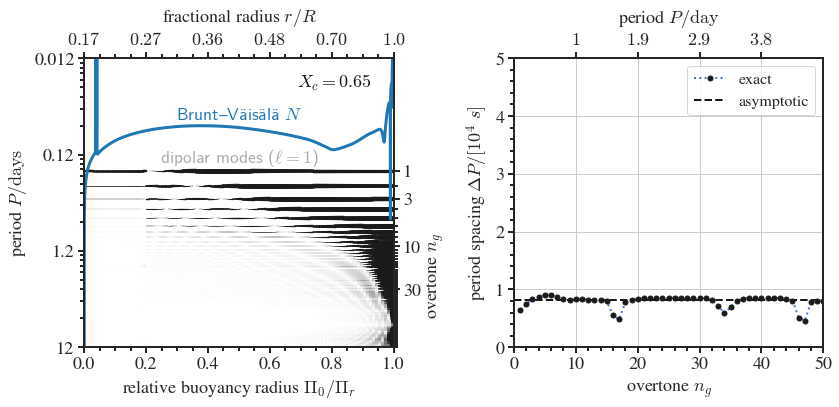

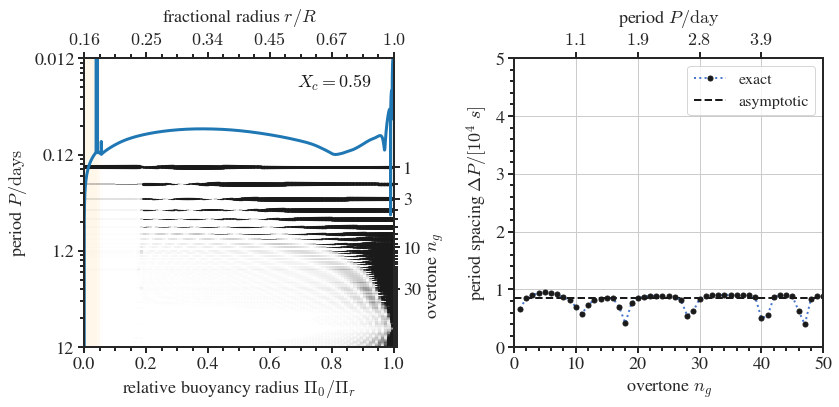

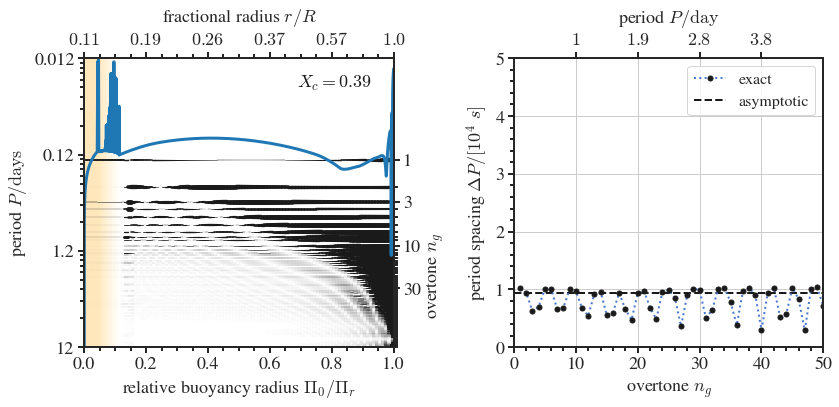

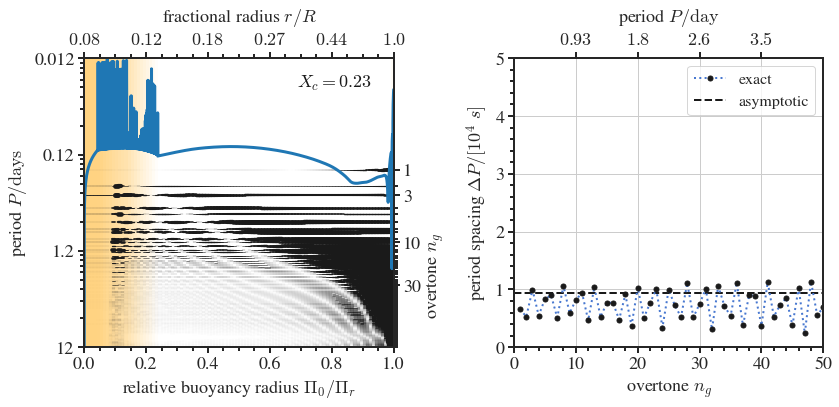

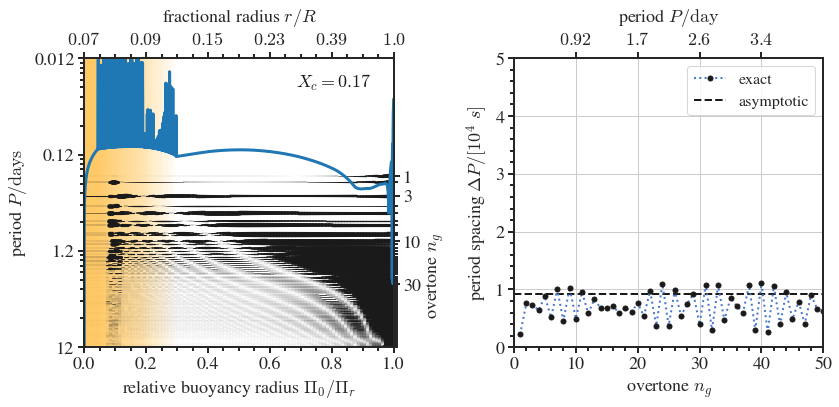

In [119]:
plot_prof('1')
#plot_prof('10', labels=False)
#plot_prof('15', labels=False)
plot_prof('2', labels=False)
plot_prof('5', labels=False)
plot_prof('10', labels=False)
plot_prof('12', labels=False)

# Debug

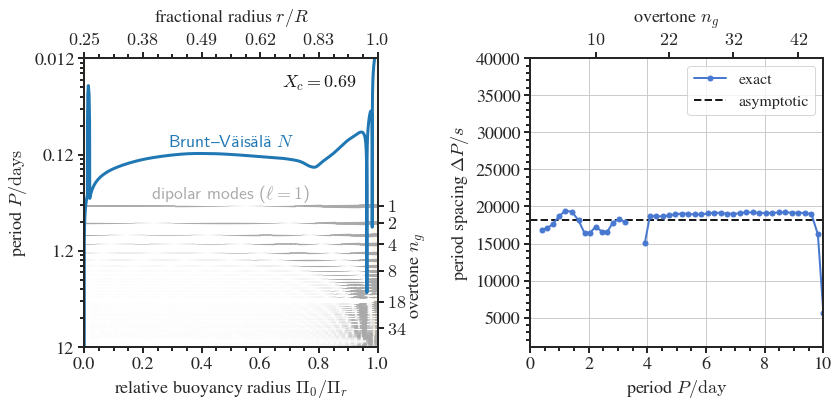

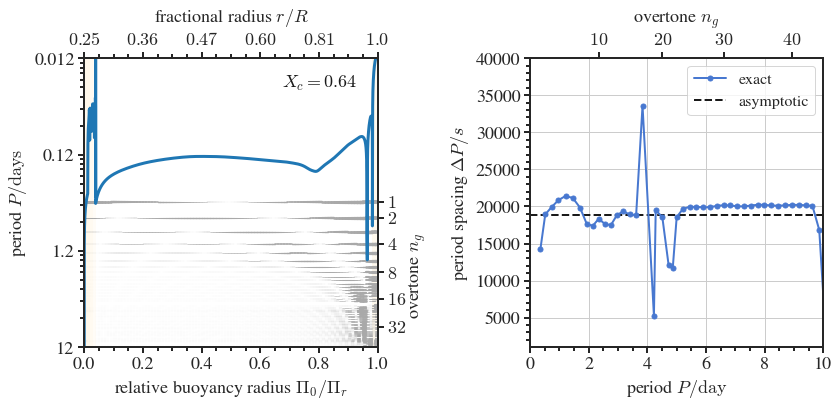

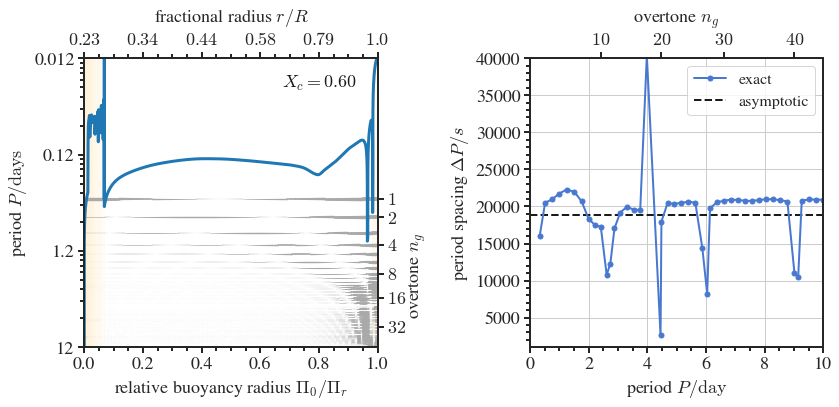

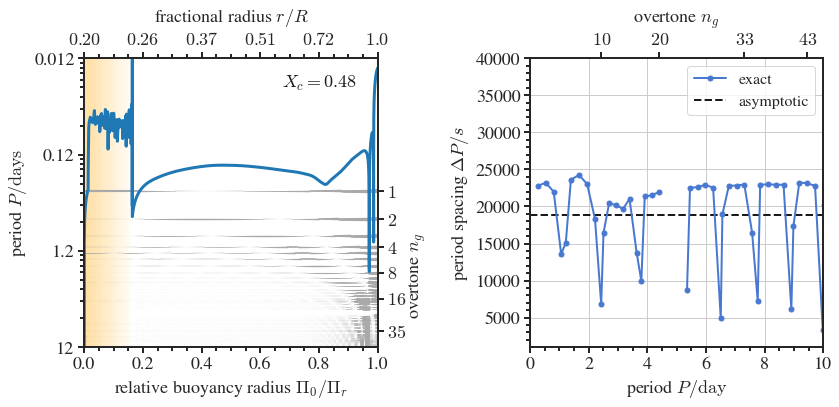

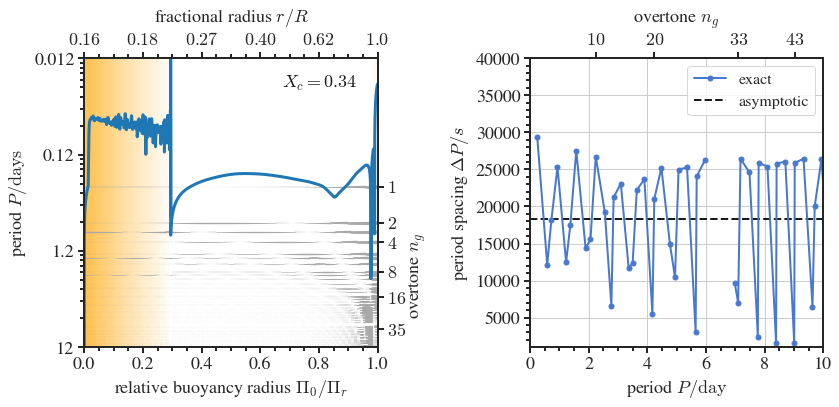

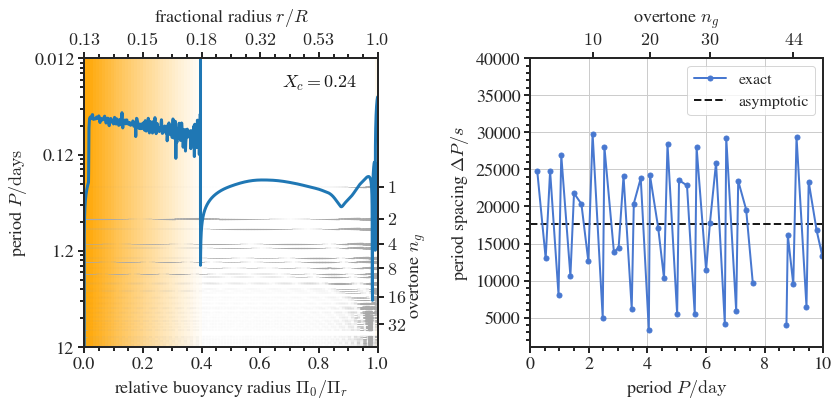

In [553]:
plot_prof('1')
plot_prof('20', labels=False)
plot_prof('40', labels=False)
plot_prof('100', labels=False)
plot_prof('200', labels=False)
plot_prof('300', labels=False)

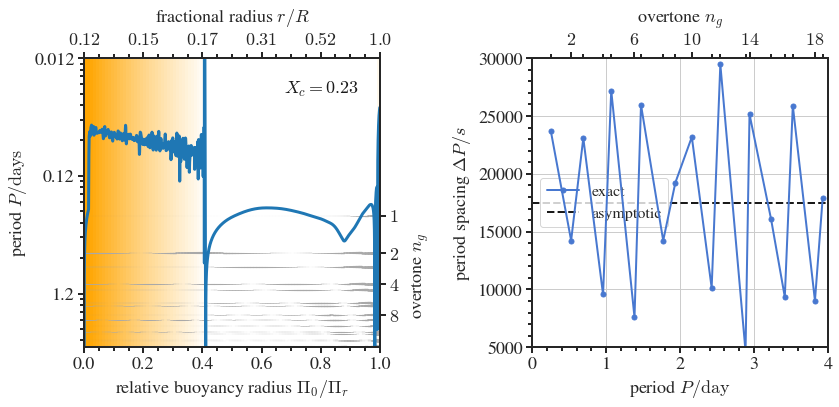

In [462]:
plot_prof('313', labels=False)

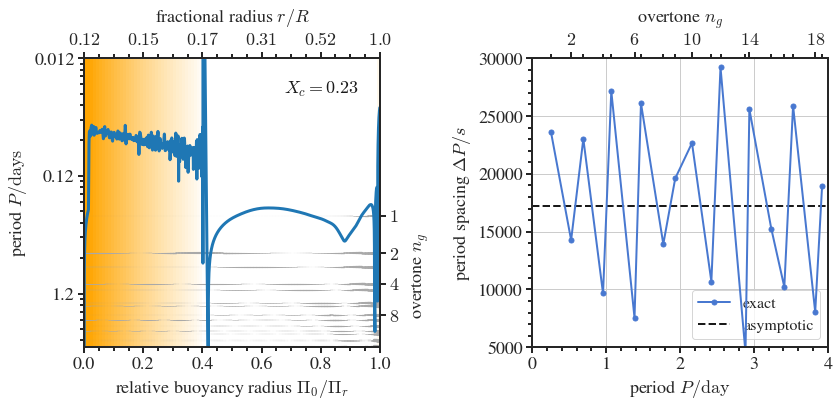

In [461]:
plot_prof('314', labels=False)

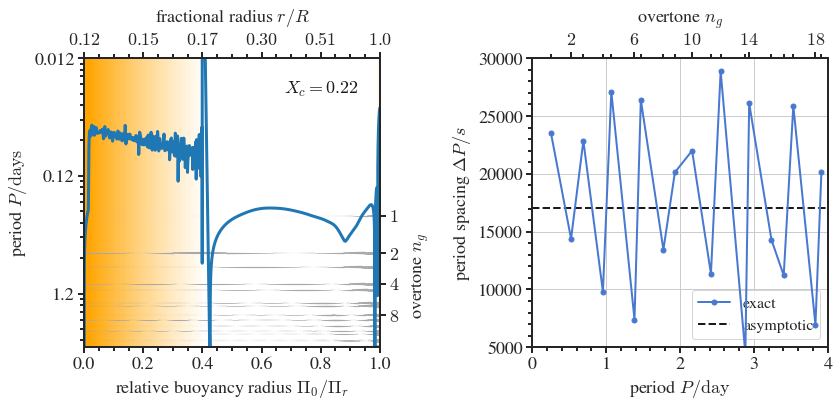

In [463]:
plot_prof('315', labels=False)

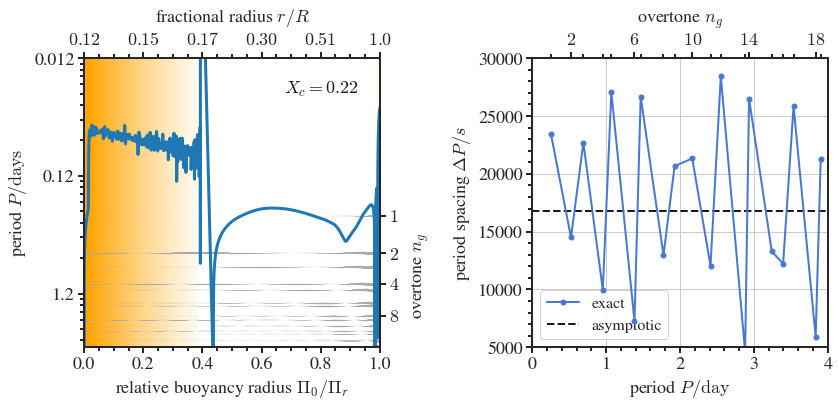

In [464]:
plot_prof('316', labels=False)

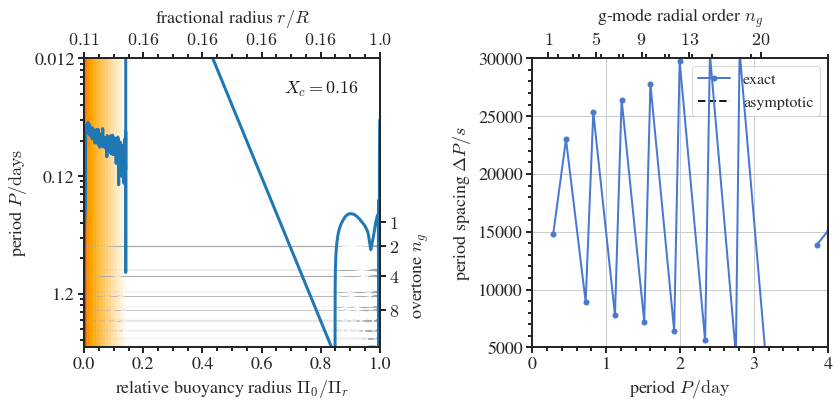

In [454]:
plot_prof('400', labels=False)

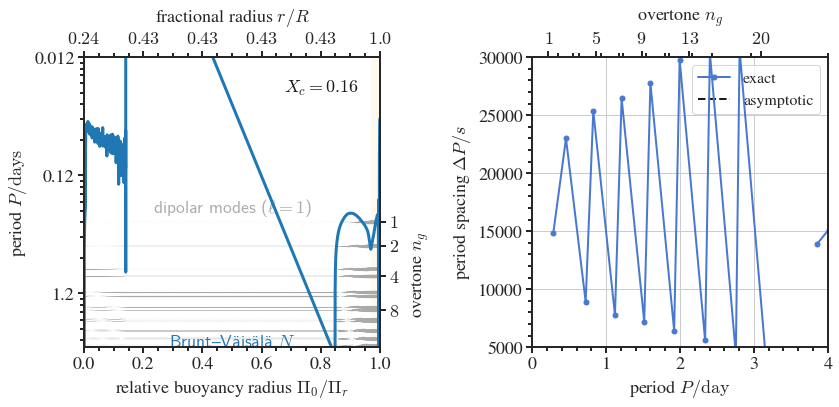

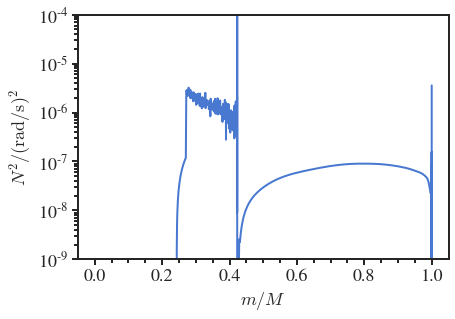

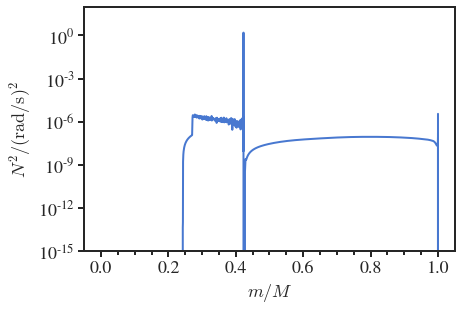

In [468]:
def plot_test(profnum, labels=True):

    prof = gyre.load_gyre(logs_dir + 'profile' + profnum + '.data.GYRE')
    model = pd.read_table(logs_dir + 'profile' + profnum + '.data', skiprows=5, sep='\s+')
    N2 = prof.N2
    N = np.sqrt([x if x>=0 else 0 for x in N2])
    
    Pi_0 = 2*np.pi**2/integrate.trapezoid(prof.N[prof.N2>0]/prof.x[prof.N2>0], prof.x[prof.N2>0])
    Pi_r = 2*np.pi**2/integrate.cumulative_trapezoid(N[prof.N2>0]/prof.x[prof.N2>0], prof.x[prof.N2>0])
    Pi_r = np.concatenate(([Pi_r[0]], + Pi_r))
    
    freqs = pd.read_table(logs_dir + 'profile' + profnum + '-freqs.dat', skiprows=5, sep='\s+')
    dipole_g = freqs[np.logical_and(np.logical_and(freqs.l == 1, freqs.n_g > 0), freqs.n_p == 0)] 
    dipole_g['P']  = 1/(dipole_g['Re(freq)'] * 10**-6) / s_per_day
    for mode in dipole_g.iterrows():
        n_g  = mode[1]['n_g']
        n_g2 = dipole_g[dipole_g['n_g'] == n_g+1]
        if not n_g2.empty:
            dP = (n_g2['P'].values[0] - mode[1]['P']) * s_per_day # period spacing in seconds 
            dipole_g.loc[mode[0], 'dP'] = dP
    
    eigs = {}
    for fname in os.listdir(logs_dir + 'profile' + profnum + '-freqs'):
        if fname[:4] != '001_':
            continue
        eig_i = pd.read_table(logs_dir + 'profile' + profnum + '-freqs/' + fname, sep='\s+', skiprows=5)
        eig_i = eig_i.iloc[np.unique(eig_i.x, return_index=True)[1]]
        eigs[int(fname.split('_')[1])] = eig_i
    
    buoy_rad = N[N2>0]/(10**-6 * 2*np.pi)
    find_pi = lambda x: prof.q[N2>0][np.where(Pi_0/Pi_r > x)[0][0]]
    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    
    # propagation diagram 
    plt.plot(Pi_0 / Pi_r, buoy_rad, 
             zorder=10, lw=3, label=r'Brunt–Väisälä',
            c='tab:blue')
    plt.xlabel(r'relative buoyancy radius $\Pi_0/\Pi_r$')
    #plt.ylabel(r'frequency $\nu/\mu\rm{Hz}$')
    plt.ylabel(r'period $P/\rm{days}$')
    plt.xlim([0,1])
    ylim = [3.5, 10**3]
    plt.ylim(ylim)
    plt.semilogy()

    ax = plt.gca()

    yticks = [10**1, 10**2, 10**3]
    nutoP = lambda x: 1/(x * 10**-6) / s_per_day
    ax.set_yticks(yticks)
    ax.set_yticklabels(['%2.2g' % nutoP(x) for x in yticks])

    if labels:
        plt.text(0.5, buoy_rad[np.where(Pi_0 / Pi_r >= 0.5)[0][0]]*1.2, r'Brunt–Väisälä $N$', ha='center',
            c='tab:blue', family='Latin Modern Sans')
    #plt.legend()
    
    plt.text(0.93, ylim[1]*0.5, r'$X_c = %.2f$' % model.x_mass_fraction_H.values[-1], 
             ha='right', c='k', family='Latin Modern Sans')

    # plot mu
    # mu ~= 4 / (6*X + Y + 2)
    norm = mpl.colors.Normalize(vmin=0.62, vmax=4/3)
    cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white","orange","red"])
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    x = 10**model.logR / np.max(10**model.logR)
    xs = np.linspace(0, 1, 101)
    for ii in range(len(xs)-1):
        x_i = (xs[ii]+xs[ii+1])/2
        col = cmap.to_rgba( model.mu[ np.argmin(np.abs(x - find_pi(x_i))) ] )
        plt.axvspan(xs[ii], xs[ii+1], zorder=-100, fc=col, ec=col)

    # plot eigenfunctions 
    for mode in dipole_g.iterrows():
        #plt.axhline(mode[1]['Re(freq)'], ls='--', c='k', alpha=0.35)
        eig = eigs[-mode[1]['n_g']]
        xir = np.abs(eig['Re(xi_r)']) / np.max(np.abs(eig['Re(xi_r)'])) * 4 / np.log10(10+mode[1]['n_g'])
        for ii in range(len(xs)-1):
            x_i = (xs[ii]+xs[ii+1])/2
            plt.plot([xs[ii], xs[ii+1]], [mode[1]['Re(freq)']]*2, 
                     ls='-', c='darkgray', alpha=1, ms=0,
                     lw=xir[ np.argmin(np.abs(eig.x - find_pi(x_i))) ] )
        #xih = np.abs(eig['Re(xi_h)']) / np.max(np.abs(eig['Re(xi_h)'])) * 5
        #for ii in range(len(xs)-1):
        #    plt.plot([xs[ii], xs[ii+1]], [mode[1]['Re(freq)']]*2, ls='-', c='darkgray', alpha=1, ms=0,
        #             lw=xih[ np.argmin(np.abs(eig.x - find_pi((xs[ii]+xs[ii+1])/2))) ] )
        if mode[1]['n_g'] == 1 and labels:
            plt.text(0.5, mode[1]['Re(freq)']*1.2, r'dipolar modes ($\ell = 1$)', ha='center',
                c='darkgray', family='Latin Modern Sans')

    top = ax.twiny()
    top.set_xlim(ax.get_xlim())
    top.set_xlabel(r'fractional radius $r/R$', labelpad=10)

    xs = [0, 0.2, 0.4, 0.6, 0.8, 0.99999]
    top.set_xticks(xs)
    top.set_xticklabels([r'$%0.2f$' % find_pi(x) if x<0.999 else r'$1.0$' for x in xs])

    ## plot overtones on the right y-axis 
    right = ax.twinx()
    right.set_ylim(ax.get_ylim())
    right.semilogy()
    right.set_ylabel(r'overtone $n_g$')
    right.yaxis.set_label_coords(1.1,0.25)

    per_spac = dipole_g[~np.isnan(dipole_g.dP)]
    #per_spac = per_spac[per_spac.P < 5]
    right.set_yticks(per_spac['Re(freq)'].values[::-1][[0,1,3,7]])
    right.set_yticklabels([r'$%s$' % x for x in per_spac.n_g.values[::-1][[0,1,3,7]]])
    right.set_yticks([], minor=True)
    #plt.savefig('propagation.pdf')

    
    # period spacings
    plt.subplot(1,2,2)
    
    plt.plot(dipole_g['P'], dipole_g['dP'], 'b.-', ms=10, zorder=10, label='exact')
    plt.xlim([0, 4])
    plt.axhline(Pi_0 / np.sqrt(2), ls='--', c='k', label=r'asymptotic')
    #plt.axhline(0, ls='--', c='k')
    plt.xlabel(r'period $P/\rm{day}$')
    plt.ylabel(r'period spacing $\Delta P/s$')
    plt.ylim([5000, 30000])

    plt.legend()

    plt.grid()

    ax = plt.gca()
    top = ax.twiny()
    top.set_xlim(ax.get_xlim())
    top.set_xlabel(r'overtone $n_g$', labelpad=10)

    per_spac = dipole_g[~np.isnan(dipole_g.dP)]
    #per_spac = per_spac[per_spac.P < 4]
    top.set_xticks(per_spac.P, minor=True)
    top.set_xticks(per_spac.P[1::4])
    top.set_xticklabels([r'$%s$' % x for x in per_spac.n_g[1::4]])
    
    plt.tight_layout()
    plt.show()
    
    plt.plot(prof.m/prof.M, N2)
    plt.xlabel(r'$m/M$')
    plt.ylabel(r'$N^2/\left(\rm{rad}/s\right)^2$')
    plt.axhline(0, ls='--', c='k', zorder=-1)
    plt.ylim([10**-9, 10**-4])
    plt.semilogy()
    plt.show()
    
    plt.plot(prof.m/prof.M, N2)
    plt.xlabel(r'$m/M$')
    plt.ylabel(r'$N^2/\left(\rm{rad}/s\right)^2$')
    plt.axhline(0, ls='--', c='k', zorder=-1)
    plt.ylim([10**-15, 10**2])
    plt.semilogy()
    plt.show()

plot_test('400')